# Mustererkennung/Machine Learning - Assignment 6



In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Load the spam dataset:

In [22]:
data = np.array(pd.read_csv('spambase.data', header=None))

X = data[:,:-1] # features
y = data[:,-1] # Last column is label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)

In [23]:
feature_names = ["word_freq_make",
"word_freq_address",
"word_freq_all",
"word_freq_3d",
"word_freq_our",
"word_freq_over",
"word_freq_remove",
"word_freq_internet",
"word_freq_order",
"word_freq_mail",
"word_freq_receive",
"word_freq_will",
"word_freq_people",
"word_freq_report",
"word_freq_addresses",
"word_freq_free",
"word_freq_business",
"word_freq_email",
"word_freq_you",
"word_freq_credit",
"word_freq_your",
"word_freq_font",
"word_freq_000",
"word_freq_money",
"word_freq_hp",
"word_freq_hpl",
"word_freq_george",
"word_freq_650",
"word_freq_lab",
"word_freq_labs",
"word_freq_telnet",
"word_freq_857",
"word_freq_data",
"word_freq_415",
"word_freq_85",
"word_freq_technology",
"word_freq_1999",
"word_freq_parts",
"word_freq_pm",
"word_freq_direct",
"word_freq_cs",
"word_freq_meeting",
"word_freq_original",
"word_freq_project",
"word_freq_re",
"word_freq_edu",
"word_freq_table",
"word_freq_conference",
"char_freq_;",
"char_freq_(",
"char_freq_[",
"char_freq_!",
"char_freq_$",
"char_freq_#",
"capital_run_length_average",
"capital_run_length_longest",
"capital_run_length_total"]

# Exercise 1. Decision Trees

In [24]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def gini(y_true, c):
    """
    For simplicity reasons this assumes that there are only 2 classes
    """
    y_true = np.array(y_true)
    p_mk = np.mean(y_true == c)

    return 2 * p_mk * (1 - p_mk)

class LeafNode():
    def fit(self, c):
        self.c = c
        
    def predict(self, x):
        return self.c
    
class InternalNode():
    def fit(self, x, y, depth, max_depth, max_features_to_sample):
        m, n = x.shape
        # columns are j, split_index, loss_total
        split_infos = []
        if max_features_to_sample == None:
            iter_over = range(n)
        else:
            # in RandomForest we build the tree only on a subset of the features at each Node
            iter_over = np.random.permutation(n)[:max_features_to_sample]
            
        for j in iter_over:
            # sort rows by feature j in ascending order
            sorted_indices = x[:,j].argsort()
            x, y = x[sorted_indices], y[sorted_indices]
            for split_index in self.get_unique_indices(x[:, j])[:-1]:
                
                y_top_split = y[:split_index + 1]
                y_bottom_split = y[split_index + 1:]
                
                if y_top_split.shape[0] == 0:
                    raise Exception("Error 1")
                    
                if y_bottom_split.shape[0] == 0:
                    raise Exception("Error 2")
                
                c1 = self.find_c(y_top_split)
                c2 = self.find_c(y_bottom_split)
                
                loss_1 = gini(y_top_split, c1)
                loss_2 = gini(y_bottom_split, c2)
                
                # use weighted average which had better results
                loss_total = (y_top_split.shape[0] / m) * loss_1  + (y_bottom_split.shape[0] / m) * loss_2
                
                row = np.array([j, split_index, loss_total])
                split_infos.append(row)
                
        split_infos = np.array(split_infos)
        best_split_idx = np.argmin(split_infos[:,-1], axis=0)
        best_split = split_infos[best_split_idx]
        self.j = int(best_split[0])
        split_index = int(best_split[1])
        
        sorted_indices = x[:,j].argsort()
        x, y = x[sorted_indices], y[sorted_indices]
        
        x_top_split, y_top_split = x[:split_index + 1], y[:split_index + 1]
        x_bottom_split, y_bottom_split = x[split_index + 1:], y[split_index + 1:]
        
        self.z = (x_top_split[-1, self.j] + x_bottom_split[0, self.j]) / 2
        
        if self.is_pure(y_top_split) or x_top_split.shape[0] <= 10 or depth >= max_depth:
            self.left_child = LeafNode()
            c = self.find_c(y_top_split)
            self.left_child.fit(c)
        else:
            self.left_child = InternalNode()
            self.left_child.fit(x_top_split, y_top_split, depth + 1, max_depth, max_features_to_sample)
            
        if self.is_pure(y_bottom_split) or x_bottom_split.shape[0] <= 10 or depth >= max_depth:
            self.right_child = LeafNode()
            c = self.find_c(y_bottom_split)
            self.right_child.fit(c)
        else:
            self.right_child = InternalNode()
            self.right_child.fit(x_bottom_split, y_bottom_split, depth + 1, max_depth, max_features_to_sample)
        
    def predict(self, x):
        if x[self.j] <= self.z:
            return self.left_child.predict(x)
        return self.right_child.predict(x)
    
    def find_c(self, y):
        """
        For simplicity reasons this assumes that there are only 2 classes
        """
        y = np.array(y)
        zeros = np.sum(y == 0)
        ones = np.sum(y == 1)
        if ones > zeros:
            return 1
        return 0
        
    def is_pure(self, y):
        y = np.array(y)
        if np.sum(y == 0) == y.shape[0] or np.sum(y == 1) == y.shape[0]:
            return True
        return False
    
    def get_unique_indices(self, arr):
        idx = []
        arr_len = len(arr)
        for i in range(len(arr)):
            if i == arr_len - 1:
                idx.append(i)
            elif arr[i] != arr[i + 1]:
                idx.append(i)
        return idx
    
class DecisionTreeClassifier():
    """
    Basically just holds the root node of the tree which starts the recursion
    features_to_sample will be set when creating a RandomForest 
    """
    def __init__(self, max_depth, features_to_sample=None):
        self.max_depth = max_depth
        self.features_to_sample = features_to_sample
        
    def fit(self, x, y):
        self.root = InternalNode()
        x = np.copy(x)
        y = np.copy(y)
        self.root.fit(x, y, 1, self.max_depth, self.features_to_sample)
    
    def predict(self, x):
        y_preds = []
        for sample in x:
            y_pred = self.root.predict(sample)
            y_preds.append(y_pred)
        return np.array(y_preds)


In [25]:
%%time

clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train, y_train)

CPU times: user 6.87 s, sys: 3.92 ms, total: 6.87 s
Wall time: 6.87 s


In [26]:
y_pred = clf.predict(X_test)
acc = accuracy(y_test, y_pred)
print(acc)

0.7254561251086012


Sklearn gives a higher accuracy than our classifier, also sometimes when training it throws errors, because split_infos is empty, something is probably wrong with how we split the dataset in each iteration when training.

### Assume that classifying a genuine E-Mail as spam is ten times worse than classifying spam as genuine. How would you change the design of your decision tree?

One way to combat class imbalance is to oversample the class which is more important. So we train with the original samples which are spam and concatenate the samples which are genuine ten times.

Another way is to directly impact the loss at each iteration of the decision tree training. If we calculate the loss of each left and right splits, we can multiply the left and right split by the number of non-spam samples samples in them. This way splits with a high loss and a lot of genuine samples are penalized and splits with a low loss and a lot of genuine samples have a lower loss relative to the other splits.

### Use your tree to analyze feature importance. Plot the difference between the top 5 features (check spambase.names to check what features those belong to).

In [27]:
feat_1 = clf.root.j
feat_2 = clf.root.left_child.j
feat_3 = clf.root.right_child.j
feat_4 = clf.root.left_child.left_child.j
feat_5 = clf.root.left_child.right_child.j

most_imp_features = [feature_names[feat_1], 
                     feature_names[feat_2], 
                     feature_names[feat_3], 
                     feature_names[feat_4], 
                     feature_names[feat_5]]

print(most_imp_features)

['char_freq_!', 'char_freq_!', 'word_freq_hp', 'word_freq_remove', 'char_freq_!']


Its possible that features repeat in the decision tree, we don't know wether that thats correct in this case or if that is because we did something wrong in our decision tree.

# Exercise 2. Random Forests

In [28]:
class RandomForestClassifier():
    def __init__(self, num_trees, bootstrap_ratio, max_depth):
        self.num_trees = num_trees
        self.bootstrap_ratio = bootstrap_ratio
        self.max_depth = max_depth
    
    def boostrap_dataset(self, x, y):
        """
        Creates a dataset with m * bootstrap_ratio samples
        drawn with replacement
        """
        size = int(x.shape[0] * self.bootstrap_ratio)
        row_indices = np.random.randint(low=0, high=x.shape[0], size=(size, ))
        return x[row_indices], y[row_indices]
            
    def fit(self, x, y):
        x = np.copy(x)
        y = np.copy(y)
        self.trees = []
        num_features = int(np.sqrt(x.shape[1]))
        for tree in range(self.num_trees):
            x_sub, y_sub = self.boostrap_dataset(x, y)
            weak_predictor = DecisionTreeClassifier(self.max_depth, num_features)
            weak_predictor.fit(x_sub, y_sub)
            self.trees.append(weak_predictor)
        
    def predict(self, x):
        y_preds = []
        for sample in x:
            votes = []
            for tree in self.trees:
                # decision tree expects matrix as input
                sample = sample.reshape((1, -1))
                votes.append(tree.predict(sample))
            votes = np.array(votes)
            if np.mean(votes) > 0.5:
                y_preds.append(1)
            else:
                y_preds.append(0)
        return np.array(y_preds)

In [29]:
accuracies = []

for num_trees in range(2, 32, 4):
    print(f"Training random forest with {num_trees} trees")
    clf = RandomForestClassifier(num_trees=num_trees, bootstrap_ratio=1, max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy(y_test, y_pred)
    accuracies.append(acc)

Training random forest with 2 trees
Training random forest with 6 trees
Training random forest with 10 trees
Training random forest with 14 trees
Training random forest with 18 trees
Training random forest with 22 trees
Training random forest with 26 trees
Training random forest with 30 trees


### Print a confusion matrix

We will print a confusion matrix for random forest with 30 trees

In [30]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[694   3]
 [208 246]]


We have a lot of false negatives (predicted as not spam, but are actually spam) and a small amount of false positives (predicted as spam, but are actually not spam).

### What is a good number of trees in the forest?

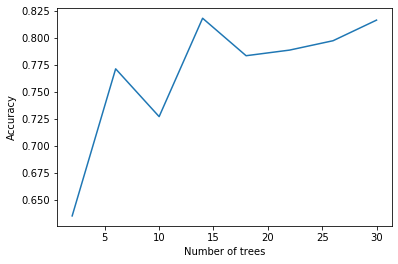

In [31]:
plt.plot(list(range(2, 32, 4)), accuracies)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.show()

Analyzing the graph we found that ~15 is a good number of trees for our problem.